
[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\Arnell\AppData\Local\Temp\ipykernel_8552\2500295703.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='GFC', data=df, ax=axs[0], palette=[color_by_year(y) for y in df['Year']])
C:\Users\Arnell\AppData\Local\Temp\ipykernel_8552\2500295703.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='TMF', data=df, ax=axs[1], palette=[color_by_year(y) for y in df['Year']])
C:\Users\Arnell\AppData\Local\Temp\ipykernel_8552\2500295703.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

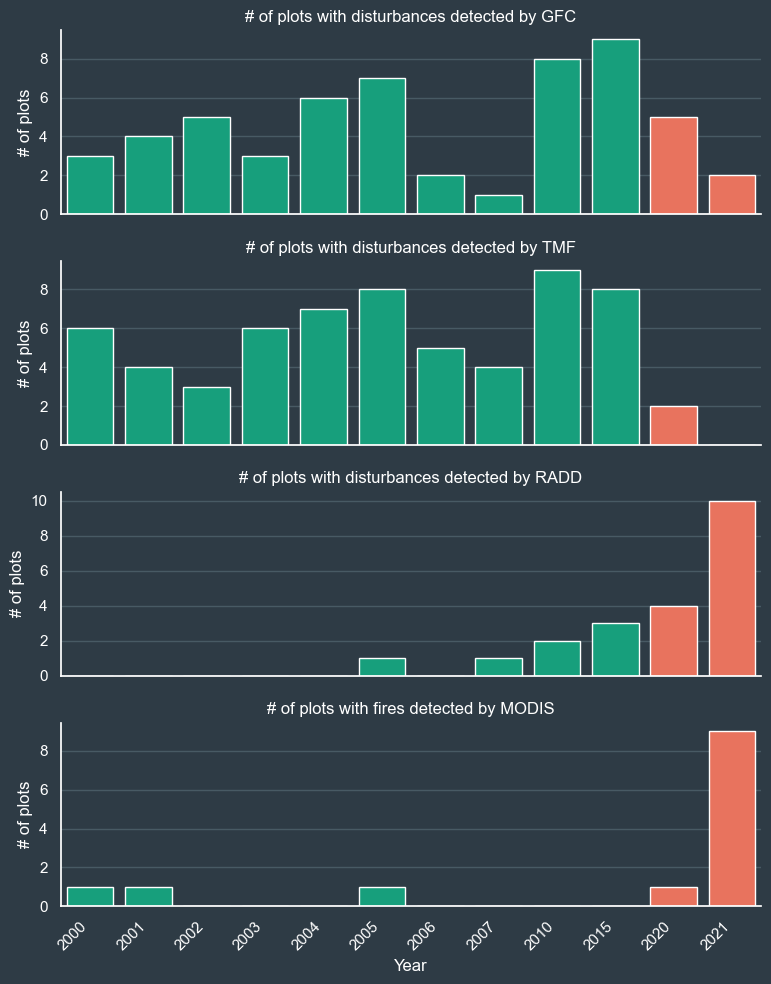

In [4]:
import pandas as pd
!pip install matplotlib seaborn
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2010, 2015, 2020,2021],
    'GFC': [3, 4, 5, 3, 6, 7, 2, 1, 8, 9, 5,2],
    'TMF': [6, 4, 3, 6, 7, 8, 5, 4, 9, 8, 2,0],
    'RADD': [0, 0, 0, 0, 0, 1, 0, 1, 2, 3, 4,10],
    'MODIS': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,9]
}

# Convert the dictionary to DataFrame
df = pd.DataFrame(data)

# Set Seaborn theme and style
sns.set_theme(style="darkgrid", rc={"axes.facecolor": "#2e3b45", "grid.color": "#485A64"})
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.labelcolor'] = '#ffffff'
plt.rcParams['xtick.color'] = '#ffffff'
plt.rcParams['ytick.color'] = '#ffffff'

# Function to assign color based on year
def color_by_year(year):
    if year >= 2020:
        return '#ff6347'  # Red from the screenshot
    else:
        return '#00b687'  # Green from the screenshot

# Plot the data
fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
fig.patch.set_facecolor('#2e3b45')  # Set background color

# GFC disturbance chart
sns.barplot(x='Year', y='GFC', data=df, ax=axs[0], palette=[color_by_year(y) for y in df['Year']])
axs[0].set_title('# of plots with disturbances detected by GFC', color='white')
axs[0].set_ylabel('# of plots', color='white')

# TMF disturbance chart
sns.barplot(x='Year', y='TMF', data=df, ax=axs[1], palette=[color_by_year(y) for y in df['Year']])
axs[1].set_title('# of plots with disturbances detected by TMF', color='white')
axs[1].set_ylabel('# of plots', color='white')

# RADD disturbance chart
sns.barplot(x='Year', y='RADD', data=df, ax=axs[2], palette=[color_by_year(y) for y in df['Year']])
axs[2].set_title('# of plots with disturbances detected by RADD', color='white')
axs[2].set_ylabel('# of plots', color='white')

# MODIS fire detection chart
sns.barplot(x='Year', y='MODIS', data=df, ax=axs[3], palette=[color_by_year(y) for y in df['Year']])
axs[3].set_title('# of plots with fires detected by MODIS', color='white')
axs[3].set_ylabel('# of plots', color='white')

# Set common properties
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save or display the plot
plt.savefig("plots_disturbances_custom_colored.png", facecolor=fig.get_facecolor(), transparent=True)
plt.show()


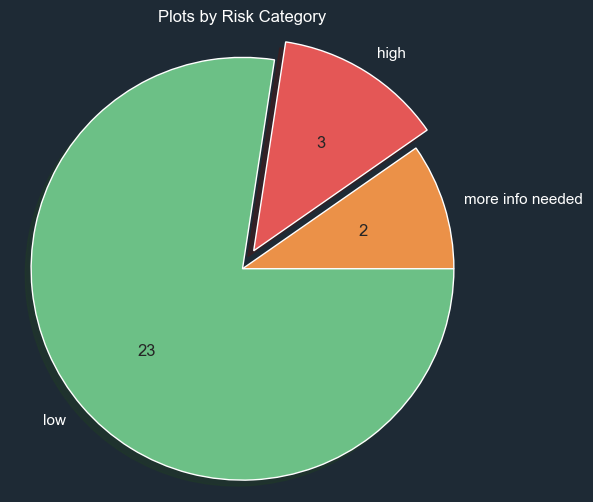

In [51]:
import matplotlib.pyplot as plt

# Data to plot (order of categories)
labels = ['more info needed', 'high', 'low']  # Labels
sizes = [3, 4, 24]  # Corresponding sizes

# Colors for each category
colors = ['#EB9148', '#E45756', '#6CC086']  # Orange, Red, Green

# Background color
background_color = '#1E2A35'

# Explode the "high" category to emphasize it
explode = (0, 0.1, 0)  # Only explode "high"

# Create a function to display absolute numbers instead of percentages
def func(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return f'{absolute}'  # Show absolute values

# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 6), facecolor=background_color)
ax.set_facecolor(background_color)

# Create the pie chart, starting at 0 degrees and going anticlockwise
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct=lambda pct: func(pct, sizes), shadow=True, 
                                   startangle=0, labeldistance=1.1)

# Position the labels outside the segments
for text in texts:
    text.set_color('white')  # Set label color to white

# Set the title
ax.set_title('Plots by Risk Category', color='white')

# Ensure a perfect circle
plt.axis('equal')

# Display the pie chart
plt.show()


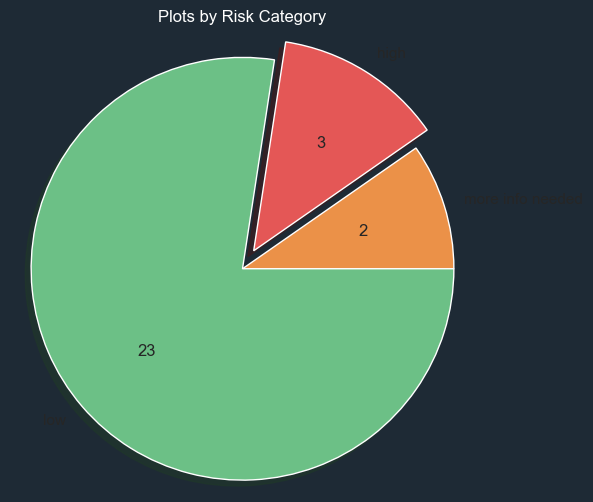